In [ ]:
# Step 1: Problem Definition

## Project Goal
Design and build a multi-task NLP model (DistilBERT-based) to jointly predict:
- **Emotion** (from text) — multi-class.
- **Intent** (from text) — multi-class.

The model will:
- Combine four heterogeneous datasets: 
  1. DailyDialog Multi-Turn Dialog + Intention Data
  2. Emotions Dataset for NLP
  3. Intent Based Mental Health Chatbot Data
  4. Mental Health Conversational Data
- Use semi-supervised learning with pseudo-labeling to leverage partially labeled data.
- Be optimized for local training/inference (CPU/GPU).
- Emphasize mental health privacy, explainability, and research reproducibility.

## Use Case
The final model powers a mental-health-aware chatbot, making safe, explainable predictions on user messages by combining emotion and intent analysis.


In [15]:
import os
import pandas as pd
import json

# Set your project root (no 'data/raw' used)
PROJECT_ROOT = r"C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT"

dataset_dirs = {
    "emotion": os.path.join(PROJECT_ROOT, "Emotions dataset for NLP"),
    "dailydialog": os.path.join(PROJECT_ROOT, "DailyDialog Multi-Turn Dialog+Intention+Emotion"),
    "chatbot": os.path.join(PROJECT_ROOT, "Intent Based Mental Health Chatbot Data"),
    "mhcd": os.path.join(PROJECT_ROOT, "Mental Health Conversational Data"),
}

def try_load_tabular(folder, filenames, colnames):
    for ext in ['txt', 'csv']:
        if all(os.path.exists(os.path.join(folder, f"{name}.{ext}")) for name in filenames):
            dfs = []
            for name in filenames:
                file = os.path.join(folder, f"{name}.{ext}")
                # Use '\t' if txt, ',' if csv
                sep = '\t' if ext == 'txt' else ','
                df = pd.read_csv(file, sep=sep, names=colnames)
                dfs.append(df)
            return pd.concat(dfs, ignore_index=True)
    raise FileNotFoundError(f"Files {filenames} with .txt or .csv not found in {folder}")

# 1️⃣ Emotions Dataset for NLP
emotion_df = try_load_tabular(
    dataset_dirs["emotion"], filenames=["train", "val", "test"], colnames=["text", "emotion"]
)
emotion_df["dataset"] = "emotion"

# 2️⃣ DailyDialog Multi-Turn
dailydialog_df = try_load_tabular(
    dataset_dirs["dailydialog"], filenames=["train", "validation", "test"], colnames=None  # Takes header from file
)
dailydialog_df["dataset"] = "dailydialog"

# 3️⃣ Intent Based Mental Health Chatbot Data (assumed intents.json)
def load_intent_json(path, dataset_name):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    samples = []
    for intent in data["intents"]:
        for pattern in intent["patterns"]:
            samples.append({"text": pattern, "intent": intent["tag"]})
    df = pd.DataFrame(samples)
    df["dataset"] = dataset_name
    return df

chatbot_json = None
chatbot_json_path = os.path.join(dataset_dirs["chatbot"], "intents.json")
if os.path.exists(chatbot_json_path):
    chatbot_json = load_intent_json(chatbot_json_path, "chatbot")
else:
    print(f"Chatbot intents.json not found at {chatbot_json_path}")

mhcd_json = None
mhcd_json_path = os.path.join(dataset_dirs["mhcd"], "intents.json")
if os.path.exists(mhcd_json_path):
    mhcd_json = load_intent_json(mhcd_json_path, "mhcd")
else:
    print(f"MHCD intents.json not found at {mhcd_json_path}")

# PREVIEW
print("EMOTION:\n", emotion_df.head())
print("DAILYDIALOG:\n", dailydialog_df.head())
if chatbot_json is not None:
    print("CHATBOT INTENT:\n", chatbot_json.head())
if mhcd_json is not None:
    print("MHCD INTENT:\n", mhcd_json.head())


EMOTION:
                                                 text  emotion  dataset
0                    i didnt feel humiliated;sadness      NaN  emotion
1  i can go from feeling so hopeless to so damned...      NaN  emotion
2  im grabbing a minute to post i feel greedy wro...      NaN  emotion
3  i am ever feeling nostalgic about the fireplac...      NaN  emotion
4                         i am feeling grouchy;anger      NaN  emotion
DAILYDIALOG:
                                               dialog                    act  \
0  ['Say , Jim , how about going for a few beers ...  [3 4 2 2 2 3 4 1 3 4]   
1  ['Can you do push-ups ? '\n " Of course I can ...          [2 1 2 2 1 1]   
2  ['Can you study with the radio on ? '\n ' No ,...            [2 1 2 1 1]   
3  ['Are you all right ? '\n ' I will be all righ...              [2 1 1 1]   
4  ['Hey John , nice skates . Are they new ? '\n ...    [2 1 2 1 1 2 1 3 4]   

                 emotion      dataset  
0  [0 0 0 0 0 0 4 4 4 4]  dailydial

In [16]:
import os
import pandas as pd
import re
import json

PROJECT_ROOT = r"C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT"
CLEAN_DIR = os.path.join(PROJECT_ROOT, "data", "clean")
os.makedirs(CLEAN_DIR, exist_ok=True)

def clean_text(text, keep_emojis=False):
    """Standard cleaning: lowercase, mask PII/links, handle emojis/punctuation."""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[\w\.-]+@[\w\.-]+', '<EMAIL>', text)
    text = re.sub(r'http\S+|www\S+', '<URL>', text)
    text = re.sub(r'\b\d{10,13}\b', '<NUM>', text)
    text = re.sub(r'@\w+', '<USER>', text)
    punct_pattern = r'[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]'
    if keep_emojis:
        text = re.sub(punct_pattern, '', text)
    else:
        text = re.sub(punct_pattern, '', text)
        emoji_pattern = re.compile(
            "["
            u"\U0001F600-\U0001F64F"
            u"\U0001F300-\U0001F5FF"
            u"\U0001F680-\U0001F6FF"
            u"\U0001F1E0-\U0001F1FF"
            "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 1️⃣ EMOTIONS DATASET FOR NLP
emo_dir = os.path.join(PROJECT_ROOT, "Emotions dataset for NLP")
for ext in ['txt', 'csv']:
    if all(os.path.exists(os.path.join(emo_dir, f"{f}.{ext}")) for f in ['train', 'val', 'test']):
        tr = pd.read_csv(os.path.join(emo_dir, f"train.{ext}"), sep='\t', header=None, names=["text_label"])
        va = pd.read_csv(os.path.join(emo_dir, f"val.{ext}"), sep='\t', header=None, names=["text_label"])
        ts = pd.read_csv(os.path.join(emo_dir, f"test.{ext}"), sep='\t', header=None, names=["text_label"])
        df_emo = pd.concat([tr, va, ts], ignore_index=True)
        # Split to text and emotion columns
        splitcols = df_emo["text_label"].str.split(";", n=1, expand=True)
        df_emo["text"] = splitcols[0]
        df_emo["emotion"] = splitcols[1]
        df_emo["source"] = "emotion"
        break
else:
    raise FileNotFoundError("Emotion dataset train/val/test (.txt or .csv) not found.")

df_emo["clean_text"] = df_emo["text"].apply(lambda x: clean_text(x, keep_emojis=True))
df_emo = df_emo.drop_duplicates(subset='clean_text').dropna(subset=["clean_text"])
df_emo = df_emo[df_emo["clean_text"].str.strip() != ""]
df_emo.to_csv(os.path.join(CLEAN_DIR, "emotion_clean.csv"), index=False)

# 2️⃣ DAILYDIALOG: Use dialog's FIRST utterance as text, include act/emotion
dd_dir = os.path.join(PROJECT_ROOT, "DailyDialog Multi-Turn Dialog+Intention+Emotion")
for ext in ["csv", "txt"]:
    if all(os.path.exists(os.path.join(dd_dir, f"{f}.{ext}")) for f in ["train", "validation", "test"]):
        dd_tr = pd.read_csv(os.path.join(dd_dir, f"train.{ext}"))
        dd_va = pd.read_csv(os.path.join(dd_dir, f"validation.{ext}"))
        dd_ts = pd.read_csv(os.path.join(dd_dir, f"test.{ext}"))
        df_dd = pd.concat([dd_tr, dd_va, dd_ts], ignore_index=True)
        break
else:
    raise FileNotFoundError("DailyDialog train/validation/test (.csv or .txt) not found.")

df_dd["source"] = "dailydialog"
if "dialog" in df_dd.columns:
    df_dd["first_text"] = df_dd["dialog"].apply(lambda x: eval(x)[0] if isinstance(x, str) and x.startswith("[") else x)
    text_col = "first_text"
elif "text" in df_dd.columns:
    text_col = "text"
else:
    text_col = None

df_dd["clean_text"] = df_dd[text_col].apply(lambda x: clean_text(x))
df_dd = df_dd.drop_duplicates(subset="clean_text").dropna(subset=['clean_text'])
df_dd = df_dd[df_dd['clean_text'].str.strip() != '']
df_dd.to_csv(os.path.join(CLEAN_DIR, "dailydialog_clean.csv"), index=False)

# 3️⃣ CHATBOT INTENT DATA
cb_dir = os.path.join(PROJECT_ROOT, "Intent Based Mental Health Chatbot Data")
cb_path = os.path.join(cb_dir, "intents.json")
if os.path.exists(cb_path):
    with open(cb_path, "r", encoding="utf-8") as f:
        cb_json = json.load(f)
    cb_samples = []
    for intent in cb_json.get("intents", []):
        for pat in intent.get("patterns", []):
            cb_samples.append({
                "text": pat,
                "intent": intent.get("tag", "unknown"),
                "source": "chatbot"
            })
    df_cb = pd.DataFrame(cb_samples)
    df_cb["clean_text"] = df_cb["text"].apply(lambda x: clean_text(x))
    df_cb = df_cb.drop_duplicates(subset="clean_text").dropna(subset=["clean_text"])
    df_cb = df_cb[df_cb['clean_text'].str.strip() != '']
    df_cb.to_csv(os.path.join(CLEAN_DIR, "chatbot_clean.csv"), index=False)
else:
    print("Warning: Chatbot dataset intents.json not found.")

# 4️⃣ MHCD INTENT DATA
mhcd_dir = os.path.join(PROJECT_ROOT, "Mental Health Conversational Data")
mhcd_path = os.path.join(mhcd_dir, "intents.json")
if os.path.exists(mhcd_path):
    with open(mhcd_path, "r", encoding="utf-8") as f:
        mhcd_json = json.load(f)
    mhcd_samples = []
    for intent in mhcd_json.get("intents", []):
        for pat in intent.get("patterns", []):
            mhcd_samples.append({
                "text": pat,
                "intent": intent.get("tag", "unknown"),
                "source": "mhcd"
            })
    df_mhcd = pd.DataFrame(mhcd_samples)
    df_mhcd["clean_text"] = df_mhcd["text"].apply(lambda x: clean_text(x))
    df_mhcd = df_mhcd.drop_duplicates(subset="clean_text").dropna(subset=["clean_text"])
    df_mhcd = df_mhcd[df_mhcd['clean_text'].str.strip() != '']
    df_mhcd.to_csv(os.path.join(CLEAN_DIR, "mhcd_clean.csv"), index=False)
else:
    print("Warning: MHCD dataset intents.json not found.")

print("All cleaned files saved to", CLEAN_DIR)


All cleaned files saved to C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT\data\clean


In [18]:
pip install nlpaug


Note: you may need to restart the kernel to use updated packages.


In [20]:
import nltk
try:
    nltk.data.find('taggers/averaged_perceptron_tagger_eng')
except LookupError:
    nltk.download('averaged_perceptron_tagger_eng')


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Shristi chandra\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.


In [21]:
import nltk
nltk.download("wordnet")


[nltk_data] Downloading package wordnet to C:\Users\Shristi
[nltk_data]     chandra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
import os
import pandas as pd
from collections import Counter
import nlpaug.augmenter.word as naw
import nltk

# ---- Ensure nltk data is available ----
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')
try:
    nltk.data.find("corpora/wordnet")
except LookupError:
    nltk.download("wordnet")

PROJECT_ROOT = r"C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT"
MERGED_DIR = os.path.join(PROJECT_ROOT, "data", "merged")
AUG_DIR = os.path.join(PROJECT_ROOT, "data", "augmented")
os.makedirs(AUG_DIR, exist_ok=True)

# Load merged corpus
merged_df = pd.read_csv(os.path.join(MERGED_DIR, "merged_corpus.csv"))

emotion_mask = merged_df["emotion"].notna() & (merged_df["emotion"] != "unknown")
emotion_df = merged_df[emotion_mask].copy()

emo_counts = Counter(emotion_df["emotion"])
min_emo_count = min(emo_counts.values())
thresh = 2 * min_emo_count

# Augmenters
syn_aug = naw.SynonymAug(aug_src='wordnet')
swap_aug = naw.RandomWordAug(action="swap")
del_aug = naw.RandomWordAug(action="delete")

augmented_rows = []
for label, count in emo_counts.items():
    if count < thresh:
        class_subset = emotion_df[emotion_df["emotion"] == label]
        aug_needed = thresh - count
        reps = max(1, aug_needed // count)
        for _, row in class_subset.iterrows():
            text = row["text"]
            for _ in range(reps):
                try:
                    aug_texts = [
                        syn_aug.augment(text),
                        swap_aug.augment(text),
                        del_aug.augment(text),
                    ]
                except Exception as e:
                    print(f"Aug error for '{text}': {e}")
                    aug_texts = []
                for atext in aug_texts:
                    if isinstance(atext, list):
                        atext = atext[0]
                    augmented_rows.append({
                        "text": atext,
                        "emotion": row["emotion"],
                        "intent": row["intent"],
                        "source": row["source"] + "_aug"
                    })

augmented_df = pd.DataFrame(augmented_rows)
final_df = pd.concat([merged_df, augmented_df], ignore_index=True)
final_df = final_df.drop_duplicates(subset=["text", "emotion", "intent"])

final_df.to_csv(os.path.join(AUG_DIR, "augmented_corpus.csv"), index=False)
print("Augmented corpus saved to", os.path.join(AUG_DIR, "augmented_corpus.csv"))


[nltk_data] Downloading package wordnet to C:\Users\Shristi
[nltk_data]     chandra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Augmented corpus saved to C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT\data\augmented\augmented_corpus.csv


In [23]:
import os
import pandas as pd
from transformers import DistilBertTokenizerFast
import numpy as np

PROJECT_ROOT = r"C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT"
AUG_DIR = os.path.join(PROJECT_ROOT, "data", "augmented")
TOKENIZED_DIR = os.path.join(PROJECT_ROOT, "data", "tokenized")
os.makedirs(TOKENIZED_DIR, exist_ok=True)

# Load your latest data
df = pd.read_csv(os.path.join(AUG_DIR, "augmented_corpus.csv"))

# Label encoding (for modeling)
emotion_set = sorted(df["emotion"].dropna().unique())
intent_set = sorted(df["intent"].dropna().unique())
emotion2id = {emo: i for i, emo in enumerate(emotion_set)}
intent2id = {intent: i for i, intent in enumerate(intent_set)}

df["emotion_id"] = df["emotion"].map(emotion2id)
df["intent_id"] = df["intent"].map(intent2id)

# Save mappings for reference
pd.Series(emotion2id).to_json(os.path.join(TOKENIZED_DIR, "emotion2id.json"))
pd.Series(intent2id).to_json(os.path.join(TOKENIZED_DIR, "intent2id.json"))

# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Tokenize sentences
tokenized = tokenizer(
    df["text"].astype(str).tolist(),
    truncation=True,
    padding="max_length",
    max_length=64,
    return_attention_mask=True
)

# Build dataframe to save
tok_df = pd.DataFrame({
    "input_ids": [np.array(x) for x in tokenized["input_ids"]],
    "attention_mask": [np.array(x) for x in tokenized["attention_mask"]],
    "emotion_id": df["emotion_id"],
    "intent_id": df["intent_id"],
    "emotion": df["emotion"],
    "intent": df["intent"],
    "source": df["source"]
})

# Save as pickle (for DataLoader usage) and CSV (optional preview)
tok_df.to_pickle(os.path.join(TOKENIZED_DIR, "tokenized.pkl"))
tok_df.to_csv(os.path.join(TOKENIZED_DIR, "tokenized.csv"), index=False)
print("Tokenized data saved to", TOKENIZED_DIR)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\Shristi chandra\.conda\envs\mhc_gpu\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning:

`huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Shristi chandra\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development



vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Tokenized data saved to C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT\data\tokenized


In [29]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# ========== PATH SETUP ==========
PROJECT_ROOT = r"C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT"
TOKENIZED_DIR = os.path.join(PROJECT_ROOT, "data", "tokenized")
SPLIT_DIR = os.path.join(PROJECT_ROOT, "data", "splits")
os.makedirs(SPLIT_DIR, exist_ok=True)

# ========== LOAD TOKENIZED DATA ==========
df = pd.read_pickle(os.path.join(TOKENIZED_DIR, "tokenized.pkl"))
SEED = 42

print(f"✅ Loaded tokenized dataset: {len(df)} samples")
print("Unique emotions:", df["emotion"].nunique())
print("Unique intents:", df["intent"].nunique())

# ========== PRE-CLEAN ==========
# Remove rows missing emotion or intent labels
df = df.dropna(subset=["emotion_id", "intent_id"]).reset_index(drop=True)

# ========== STRATIFIED SPLIT ==========
min_samples_per_split = 4  # starting point
while True:
    counts = df["emotion"].value_counts()
    keep_classes = counts[counts >= min_samples_per_split].index
    df_filtered = df[df["emotion"].isin(keep_classes)].copy().reset_index(drop=True)
    df_filtered["emotion_id"] = df_filtered["emotion"].astype("category").cat.codes

    try:
        train_df, test_df = train_test_split(
            df_filtered,
            test_size=0.2,
            random_state=SEED,
            stratify=df_filtered["emotion_id"],
        )
        val_df, test_df = train_test_split(
            test_df,
            test_size=0.5,
            random_state=SEED,
            stratify=test_df["emotion_id"],
        )
        print(f"✅ Success with min_samples_per_split = {min_samples_per_split}")
        break
    except ValueError as e:
        print(f"❌ Failed with {min_samples_per_split}: {e}")
        min_samples_per_split += 2  # increase cutoff and retry

# ========== INFO ==========
print(f"\n📊 Split sizes → Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
print("Train class balance (%):")
print(100 * train_df["emotion"].value_counts(normalize=True).round(4).head(10))

# ========== SAVE ==========
train_df.to_pickle(os.path.join(SPLIT_DIR, "train.pkl"))
val_df.to_pickle(os.path.join(SPLIT_DIR, "val.pkl"))
test_df.to_pickle(os.path.join(SPLIT_DIR, "test.pkl"))
train_df.to_csv(os.path.join(SPLIT_DIR, "train.csv"), index=False)
val_df.to_csv(os.path.join(SPLIT_DIR, "val.csv"), index=False)
test_df.to_csv(os.path.join(SPLIT_DIR, "test.csv"), index=False)

print("\n✅ Data splits saved to:", SPLIT_DIR)


✅ Loaded tokenized dataset: 40341 samples
Unique emotions: 2628
Unique intents: 5667
❌ Failed with 4: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
❌ Failed with 6: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
❌ Failed with 8: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
✅ Success with min_samples_per_split = 10

📊 Split sizes → Train: 24500, Val: 3062, Test: 3063
Train class balance (%):
emotion
joy              22.00
sadness          18.91
anger             8.82
fear              7.73
unknown           7.37
love              5.32
[0 0 0 0]         4.49
surprise          2.33
[0 0 0 0 0 0]     2.21
[0 0 0 0 0]       1.87
Name: proportion, dtype: float64

✅ Data splits saved to: C:\Users\Shristi chandra\OneDrive\Desktop\Ment

In [31]:
pip install --upgrade transformers


Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertModel, DistilBertTokenizerFast
from torch.optim import AdamW  # Correct AdamW import
from sklearn.metrics import f1_score
import pandas as pd

# ============ PARAMETERS ============
PROJECT_ROOT = r"C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT"
SPLIT_DIR = os.path.join(PROJECT_ROOT, "data", "splits")
MODEL_DIR = os.path.join(PROJECT_ROOT, "models")
os.makedirs(MODEL_DIR, exist_ok=True)

MAX_EPOCHS = 8
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
PATIENCE = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============ DATASET CLASS ============
class MultiTaskDataset(Dataset):
    def __init__(self, df):
        self.input_ids = df["input_ids"].values
        self.attention_mask = df["attention_mask"].values
        self.emotion_labels = df["emotion_id"].values
        self.intent_labels = df["intent_id"].values
        
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx], dtype=torch.long),
            "attention_mask": torch.tensor(self.attention_mask[idx], dtype=torch.long),
            "emotion_labels": torch.tensor(self.emotion_labels[idx], dtype=torch.long),
            "intent_labels": torch.tensor(self.intent_labels[idx], dtype=torch.long),
        }

# ============ MODEL DEFINITION ============
class DistilBERTMTL(nn.Module):
    def __init__(self, model_name, num_emotions, num_intents, dropout=0.3):
        super(DistilBERTMTL, self).__init__()
        self.encoder = DistilBertModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        self.emotion_classifier = nn.Linear(hidden_size, num_emotions)
        self.intent_classifier = nn.Linear(hidden_size, num_intents)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:,0]  # CLS token embedding
        pooled_output = self.dropout(pooled_output)
        emotion_logits = self.emotion_classifier(pooled_output)
        intent_logits = self.intent_classifier(pooled_output)
        return emotion_logits, intent_logits

# ============ LOAD DATA ============
def load_split(split_name):
    df = pd.read_pickle(os.path.join(SPLIT_DIR, f"{split_name}.pkl"))
    return MultiTaskDataset(df)

def collate_fn(batch):
    input_ids = torch.stack([x["input_ids"] for x in batch])
    attention_mask = torch.stack([x["attention_mask"] for x in batch])
    emotion_labels = torch.stack([x["emotion_labels"] for x in batch])
    intent_labels = torch.stack([x["intent_labels"] for x in batch])
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "emotion_labels": emotion_labels,
        "intent_labels": intent_labels
    }

train_ds = load_split("train")
val_ds = load_split("val")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# ============ TRAINING LOOP ============
def train_epoch(model, dataloader, optimizer, criterion_emotion, criterion_intent):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        emotion_labels = batch["emotion_labels"].to(DEVICE)
        intent_labels = batch["intent_labels"].to(DEVICE)
        
        emotion_logits, intent_logits = model(input_ids, attention_mask)
        
        loss_emotion = criterion_emotion(emotion_logits, emotion_labels)
        loss_intent = criterion_intent(intent_logits, intent_labels)
        loss = 0.5 * loss_emotion + 0.5 * loss_intent
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(dataloader)

def eval_epoch(model, dataloader, criterion_emotion, criterion_intent):
    model.eval()
    total_loss = 0
    all_emotion_preds, all_emotion_labels = [], []
    all_intent_preds, all_intent_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            emotion_labels = batch["emotion_labels"].to(DEVICE)
            intent_labels = batch["intent_labels"].to(DEVICE)

            emotion_logits, intent_logits = model(input_ids, attention_mask)

            loss_emotion = criterion_emotion(emotion_logits, emotion_labels)
            loss_intent = criterion_intent(intent_logits, intent_labels)
            loss = 0.5 * loss_emotion + 0.5 * loss_intent

            total_loss += loss.item()

            emotion_preds = torch.argmax(emotion_logits, dim=1).cpu()
            intent_preds = torch.argmax(intent_logits, dim=1).cpu()

            all_emotion_preds.extend(emotion_preds.numpy())
            all_emotion_labels.extend(emotion_labels.cpu().numpy())
            all_intent_preds.extend(intent_preds.numpy())
            all_intent_labels.extend(intent_labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    emotion_f1 = f1_score(all_emotion_labels, all_emotion_preds, average="macro", zero_division=0)
    intent_f1 = f1_score(all_intent_labels, all_intent_preds, average="macro", zero_division=0)

    return avg_loss, emotion_f1, intent_f1

# ============ MAIN TRAINING ============

def main():
    model_name = "distilbert-base-uncased"

    num_emotions = train_ds.emotion_labels.max().item() + 1
    num_intents = train_ds.intent_labels.max().item() + 1

    model = DistilBERTMTL(model_name, num_emotions, num_intents).to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    
    criterion_emotion = nn.CrossEntropyLoss(ignore_index=-100)
    criterion_intent = nn.CrossEntropyLoss(ignore_index=-100)

    best_val_f1 = 0
    patience_counter = 0

    for epoch in range(MAX_EPOCHS):
        train_loss = train_epoch(model, train_loader, optimizer, criterion_emotion, criterion_intent)
        val_loss, val_emotion_f1, val_intent_f1 = eval_epoch(model, val_loader, criterion_emotion, criterion_intent)

        print(f"Epoch {epoch+1}/{MAX_EPOCHS} - Train loss: {train_loss:.4f} - Val loss: {val_loss:.4f} - Val Emotion F1: {val_emotion_f1:.4f} - Val Intent F1: {val_intent_f1:.4f}")

        avg_val_f1 = (val_emotion_f1 + val_intent_f1) / 2
        if avg_val_f1 > best_val_f1:
            best_val_f1 = avg_val_f1
            patience_counter = 0
            model_save_path = os.path.join(MODEL_DIR, "best_mtl_model.pt")
            torch.save(model.state_dict(), model_save_path)
            print(f"Saved best model to {model_save_path}")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping triggered.")
                break

if __name__ == "__main__":
    main()


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

C:\Users\Shristi chandra\.conda\envs\mhc_gpu\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Shristi chandra\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Epoch 1/8 - Train loss: 2.0868 - Val loss: 1.6020 - Val Emotion F1: 0.0684 - Val Intent F1: 0.0125
Saved best model to C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT\models\best_mtl_model.pt
Epoch 2/8 - Train loss: 1.4749 - Val loss: 1.5431 - Val Emotion F1: 0.0833 - Val Intent F1: 0.0190
Saved best model to C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT\models\best_mtl_model.pt
Epoch 3/8 - Train loss: 1.3475 - Val loss: 1.5168 - Val Emotion F1: 0.0837 - Val Intent F1: 0.0204
Saved best model to C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT\models\best_mtl_model.pt
Epoch 4/8 - Train loss: 1.2484 - Val loss: 1.5194 - Val Emotion F1: 0.0929 - Val Intent F1: 0.0238
Saved best model to C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT\models\best_mtl_model.pt
Epoch 5/8 - Train loss: 1.1487 - Val loss: 1.5577 - Val Emotion F1: 0.0956 - Val Intent F1: 0.0278
Saved best model to C:\Users\Shristi chandra\OneDrive\Desktop\Men

In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ====== PATHS ======
PROJECT_ROOT = r"C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT"
MODEL_DIR = os.path.join(PROJECT_ROOT, "models")
os.makedirs(MODEL_DIR, exist_ok=True)

# ====== TRAINING LOG DATA (from your console output) ======
# Fill in directly from your results
log_data = {
    "epoch":    [1,2,3,4,5,6,7,8],
    "train_loss": [2.0868, 1.4749, 1.3475, 1.2484, 1.1487, 1.0545, 0.9616, 0.8718],
    "val_loss":   [1.6020, 1.5431, 1.5168, 1.5194, 1.5577, 1.5508, 1.5750, 1.6099],
    "val_emotion_f1": [0.0684, 0.0833, 0.0837, 0.0929, 0.0956, 0.1001, 0.1036, 0.1180],
    "val_intent_f1":  [0.0125, 0.0190, 0.0204, 0.0238, 0.0278, 0.0252, 0.0304, 0.0304]
}

df = pd.DataFrame(log_data)

# Save metrics to your models directory
metrics_path = os.path.join(MODEL_DIR, "DistilBERTMTL_training_metrics.csv")
df.to_csv(metrics_path, index=False)
print(f"✅ Metrics saved to: {metrics_path}")


✅ Metrics saved to: C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT\models\DistilBERTMTL_training_metrics.csv


Loaded Metrics:
    epoch  train_loss  val_loss  val_emotion_f1  val_intent_f1
0      1      2.0868    1.6020          0.0684         0.0125
1      2      1.4749    1.5431          0.0833         0.0190
2      3      1.3475    1.5168          0.0837         0.0204
3      4      1.2484    1.5194          0.0929         0.0238
4      5      1.1487    1.5577          0.0956         0.0278


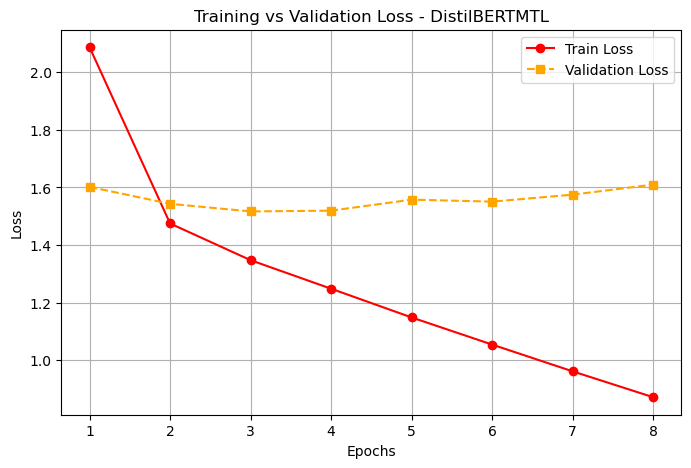

📉 Saved loss curve at: C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT\models\DistilBERTMTL_LossCurve.png


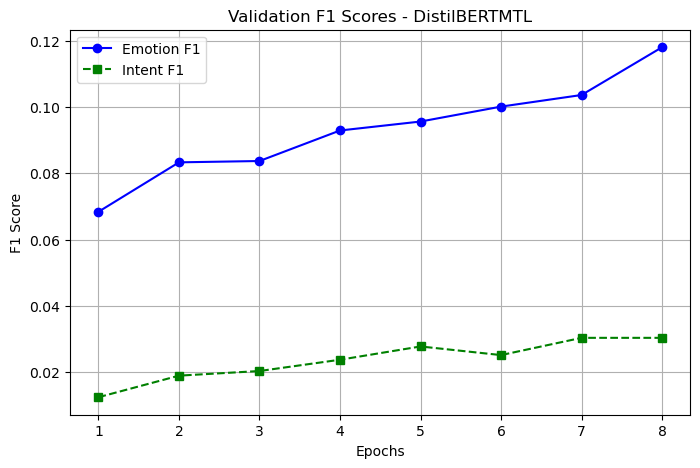

📊 Saved F1 curve at: C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT\models\DistilBERTMTL_F1Curve.png


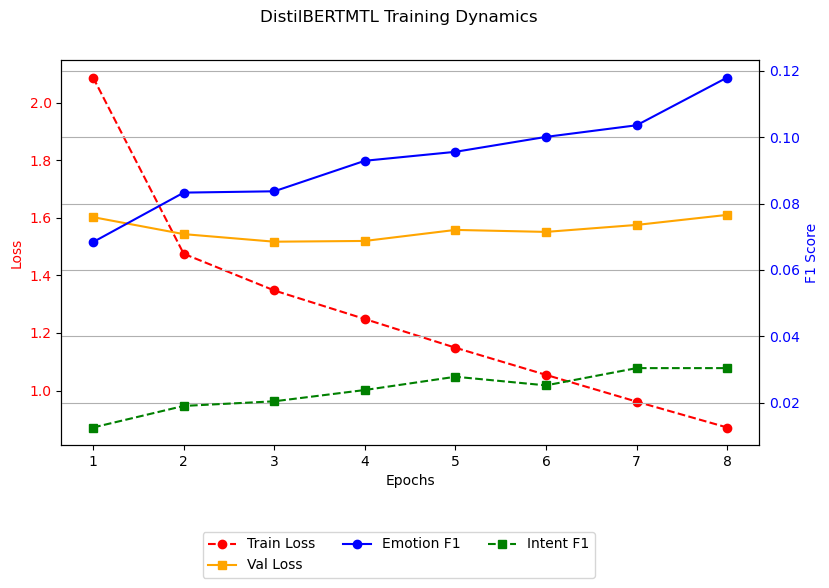

📈 Saved combined curve at: C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT\models\DistilBERTMTL_CombinedCurve.png


In [20]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ====== PATHS ======
PROJECT_ROOT = r"C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT"
MODEL_DIR = os.path.join(PROJECT_ROOT, "models")
metrics_path = os.path.join(MODEL_DIR, "DistilBERTMTL_training_metrics.csv")

# ====== LOAD METRICS ======
df = pd.read_csv(metrics_path)
print("Loaded Metrics:\n", df.head())

epochs = df["epoch"]
train_loss = df["train_loss"]
val_loss = df["val_loss"]
val_emotion_f1 = df["val_emotion_f1"]
val_intent_f1 = df["val_intent_f1"]

# ====== LOSS CURVE ======
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, 'o-', label="Train Loss", color="red")
plt.plot(epochs, val_loss, 's--', label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - DistilBERTMTL")
plt.legend()
plt.grid(True)
loss_path = os.path.join(MODEL_DIR, "DistilBERTMTL_LossCurve.png")
plt.savefig(loss_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"📉 Saved loss curve at: {loss_path}")

# ====== F1 SCORE CURVES ======
plt.figure(figsize=(8,5))
plt.plot(epochs, val_emotion_f1, 'o-', label="Emotion F1", color="blue")
plt.plot(epochs, val_intent_f1, 's--', label="Intent F1", color="green")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Validation F1 Scores - DistilBERTMTL")
plt.legend()
plt.grid(True)
f1_path = os.path.join(MODEL_DIR, "DistilBERTMTL_F1Curve.png")
plt.savefig(f1_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"📊 Saved F1 curve at: {f1_path}")

# ====== COMBINED CURVE ======
fig, ax1 = plt.subplots(figsize=(9,5))
ax1.plot(epochs, train_loss, 'o--', color="red", label="Train Loss")
ax1.plot(epochs, val_loss, 's-', color="orange", label="Val Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss", color="red")
ax1.tick_params(axis='y', labelcolor="red")

ax2 = ax1.twinx()
ax2.plot(epochs, val_emotion_f1, 'o-', color="blue", label="Emotion F1")
ax2.plot(epochs, val_intent_f1, 's--', color="green", label="Intent F1")
ax2.set_ylabel("F1 Score", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")

fig.suptitle("DistilBERTMTL Training Dynamics")
fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=3)
plt.grid(True)
combined_path = os.path.join(MODEL_DIR, "DistilBERTMTL_CombinedCurve.png")
plt.savefig(combined_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"📈 Saved combined curve at: {combined_path}")


In [1]:
import os
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertModel
from torch.optim import AdamW
from sklearn.metrics import f1_score

# ========== PATHS ==========
PROJECT_ROOT = r"C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT"
TOKENIZED_DIR = os.path.join(PROJECT_ROOT, "data", "tokenized")
PIPELINE_DIR = os.path.join(PROJECT_ROOT, "data", "harmonized_pipeline")
os.makedirs(PIPELINE_DIR, exist_ok=True)
MODEL_DIR = os.path.join(PROJECT_ROOT, "models")
os.makedirs(MODEL_DIR, exist_ok=True)

# ========== LABEL HARMONIZATION ==========
broad_label_map = {
    "joy": "joy", "happy": "joy", "love": "joy", "happiness": "joy", "pleasure": "joy",
    "surprise": "surprise", "amazed": "surprise",
    "sadness": "sadness", "sad": "sadness", "grief": "sadness",
    "anger": "anger", "angry": "anger", "frustration": "anger",
    "disgust": "disgust",
    "fear": "fear", "anxiety": "fear",
    "neutral": "neutral", "calm": "neutral", "content": "neutral",
    "unknown": "unknown", "none": "unknown"
}
core_emotions = ["joy", "sadness", "anger", "fear", "disgust", "surprise", "neutral", "unknown"]

def harmonize_label(label):
    if isinstance(label, str):
        if re.fullmatch(r"\[([ 0-9]+)\]", label):
            arr = np.fromstring(label.strip("[]"), sep=' ')
            idx = int(np.nanargmax(arr))
            if idx < len(core_emotions):
                return core_emotions[idx]
            else:
                return "unknown"
        for k, v in broad_label_map.items():
            if k in label.lower():
                return v
        return "unknown"
    return "unknown"

# ========== LOAD DATA AND HARMONIZE ==========
df = pd.read_pickle(os.path.join(TOKENIZED_DIR, "tokenized.pkl"))
df["harmonized_emotion"] = df["emotion"].apply(harmonize_label)

print("Harmonized emotion class counts:\n", df["harmonized_emotion"].value_counts())

# ========== STRATIFIED SPLIT ==========
min_samples_per_split = 6
while True:
    counts = df["harmonized_emotion"].value_counts()
    keep_classes = counts[counts >= min_samples_per_split].index
    df_filtered = df[df["harmonized_emotion"].isin(keep_classes)].reset_index(drop=True)
    try:
        train_df, test_df = train_test_split(
            df_filtered, test_size=0.2, random_state=42, stratify=df_filtered["harmonized_emotion"])
        val_df, test_df = train_test_split(
            test_df, test_size=0.5, random_state=42, stratify=test_df["harmonized_emotion"])
        break
    except ValueError as e:
        print(f"Failed with min = {min_samples_per_split}: {e}")
        min_samples_per_split += 2

# ========== CONSISTENT CATEGORY ENCODING ==========
all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
cat = pd.Categorical(all_df["harmonized_emotion"])
cat_map = {v: i for i, v in enumerate(cat.categories)}
for subset in [train_df, val_df, test_df]:
    subset["harmonized_emotion_id"] = subset["harmonized_emotion"].map(cat_map).astype(int)

print("Split sizes:", len(train_df), len(val_df), len(test_df))
print("Train unique labels:", sorted(train_df["harmonized_emotion_id"].unique()))
print("Val unique labels:", sorted(val_df["harmonized_emotion_id"].unique()))
print("Test unique labels:", sorted(test_df["harmonized_emotion_id"].unique()))
print("Total classes:", len(cat.categories))

# Save splits
train_df.to_pickle(os.path.join(PIPELINE_DIR, "train.pkl"))
val_df.to_pickle(os.path.join(PIPELINE_DIR, "val.pkl"))
test_df.to_pickle(os.path.join(PIPELINE_DIR, "test.pkl"))

# ========== DATASET AND MODEL ==========
class MultiTaskDataset(Dataset):
    def __init__(self, df):
        self.input_ids = df["input_ids"].values
        self.attention_mask = df["attention_mask"].values
        self.emotion_labels = df["harmonized_emotion_id"].values
        self.intent_labels = df["intent_id"].values
    def __len__(self): return len(self.input_ids)
    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx], dtype=torch.long),
            "attention_mask": torch.tensor(self.attention_mask[idx], dtype=torch.long),
            "emotion_labels": torch.tensor(self.emotion_labels[idx], dtype=torch.long),
            "intent_labels": torch.tensor(self.intent_labels[idx], dtype=torch.long),
        }
class DistilBERTMTL(nn.Module):
    def __init__(self, model_name, num_emotions, num_intents, dropout=0.3):
        super().__init__()
        from transformers import DistilBertModel
        self.encoder = DistilBertModel.from_pretrained(model_name)
        h_size = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        self.emotion_classifier = nn.Linear(h_size, num_emotions)
        self.intent_classifier = nn.Linear(h_size, num_intents)
    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.dropout(outputs.last_hidden_state[:, 0])
        return self.emotion_classifier(pooled), self.intent_classifier(pooled)
def collate_fn(batch):
    return {k: torch.stack([x[k] for x in batch]) for k in batch[0]}
def load_split(split_name):
    df = pd.read_pickle(os.path.join(PIPELINE_DIR, f"{split_name}.pkl"))
    return MultiTaskDataset(df)

device = "cuda" if torch.cuda.is_available() else "cpu"
train_loader = DataLoader(load_split("train"), batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(load_split("val"), batch_size=16, collate_fn=collate_fn)

# ========== TRAINING LOOP ==========
def train_epoch(model, dataloader, optimizer, crit_emotion, crit_intent):
    model.train(); total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        emotion_labels = batch["emotion_labels"].to(device)
        intent_labels = batch["intent_labels"].to(device)
        emotion_logits, intent_logits = model(input_ids, attention_mask)
        loss_emotion = crit_emotion(emotion_logits, emotion_labels)
        loss_intent = crit_intent(intent_logits, intent_labels)
        loss = 0.5 * loss_emotion + 0.5 * loss_intent
        loss.backward(); optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)
def eval_epoch(model, dataloader, crit_emotion, crit_intent):
    model.eval(); total_loss = 0; all_em, all_em_y, all_in, all_in_y = [], [], [], []
    with torch.no_grad():
        for batch in dataloader:
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            em_y = batch["emotion_labels"].to(device)
            in_y = batch["intent_labels"].to(device)
            em_logits, in_logits = model(ids, mask)
            loss_em = crit_emotion(em_logits, em_y)
            loss_in = crit_intent(in_logits, in_y)
            loss = 0.5 * loss_em + 0.5 * loss_in; total_loss += loss.item()
            all_em.extend(torch.argmax(em_logits,1).cpu().numpy())
            all_em_y.extend(em_y.cpu().numpy())
            all_in.extend(torch.argmax(in_logits,1).cpu().numpy())
            all_in_y.extend(in_y.cpu().numpy())
    return (total_loss/len(dataloader),
            f1_score(all_em_y, all_em, average="macro", zero_division=0),
            f1_score(all_in_y, all_in, average="macro", zero_division=0))
def main():
    model_name = "distilbert-base-uncased"
    num_classes = len(cat.categories)
    train_ds = pd.read_pickle(os.path.join(PIPELINE_DIR, "train.pkl"))
    num_intents = train_ds["intent_id"].max() + 1
    model = DistilBERTMTL(model_name, num_classes, num_intents).to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    crit_em = nn.CrossEntropyLoss(ignore_index=-100)
    crit_in = nn.CrossEntropyLoss(ignore_index=-100)
    best = 0; patience = 0
    for epoch in range(8):
        t_loss = train_epoch(model, train_loader, optimizer, crit_em, crit_in)
        v_loss, v_f1_e, v_f1_i = eval_epoch(model, val_loader, crit_em, crit_in)
        print(f"Epoch {epoch+1} | Train loss: {t_loss:.4f} | Val loss: {v_loss:.4f} | Val Emotion F1: {v_f1_e:.4f} | Val Intent F1: {v_f1_i:.4f}")
        avgf1 = (v_f1_e + v_f1_i)/2
        if avgf1 > best:
            best = avgf1; patience = 0
            torch.save(model.state_dict(), os.path.join(MODEL_DIR, "best_mtl_model.pt"))
        else: patience += 1
        if patience>=3: print("Early stopping."); break
if __name__ == "__main__":
    main()


Harmonized emotion class counts:
 harmonized_emotion
joy         16514
sadness      7732
unknown      4822
anger        4219
fear         3670
surprise     1518
disgust      1034
neutral       832
Name: count, dtype: int64
Split sizes: 32272 4034 4035
Train unique labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
Val unique labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
Test unique labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
Total classes: 8
Epoch 1 | Train loss: 2.4698 | Val loss: 2.2143 | Val Emotion F1: 0.5217 | Val Intent F1: 0.0060
Epoch 2 | Train loss: 2.0354 | Val loss: 2.0790 | Val Emotion F1: 0.5818 | Val Intent F1: 0.0091
Epoch 3 | Train loss: 1.8088 | Val loss: 1.9960 | Val Emotion F1: 0.6458 | Val Intent F1: 0.0296
Epoch 4 | Train loss: 1.6052 | Val loss: 1.8741 | Val Emotion F1:

✅ Metrics saved to: C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT\models\training_metrics.csv
📉 Saved loss curve: C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT\models\loss_curve.png


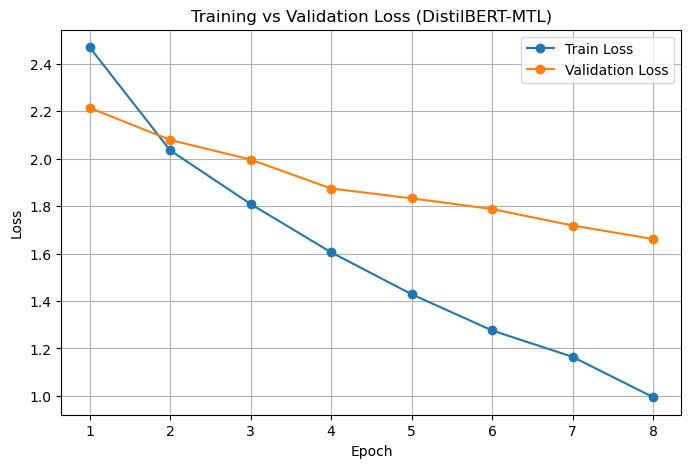

📊 Saved F1 curve: C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT\models\f1_curve.png


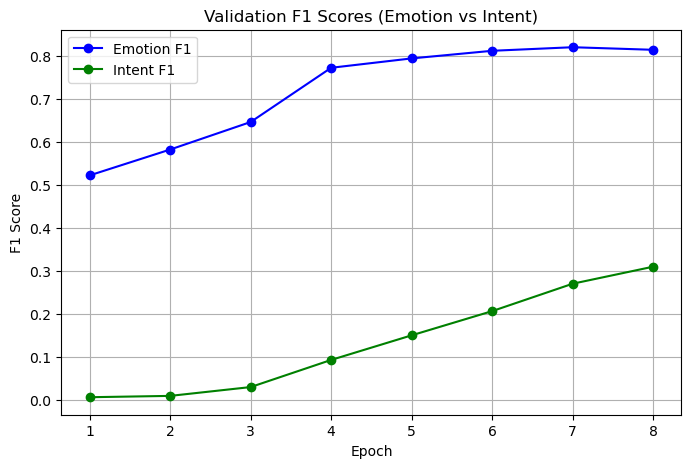

📈 Saved combined plot: C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT\models\combined_curve.png


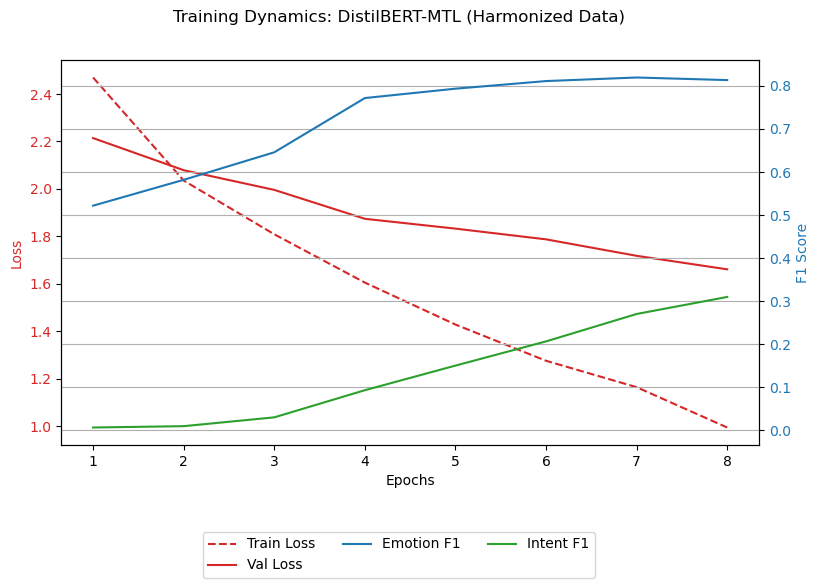

In [16]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ========= PATH SETTINGS =========
PROJECT_ROOT = r"C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT"
MODEL_DIR = os.path.join(PROJECT_ROOT, "models")
os.makedirs(MODEL_DIR, exist_ok=True)

# ========= TRAINING METRICS =========
# Replace these with your actual logged values (from terminal output)
epochs = [1, 2, 3, 4, 5, 6, 7, 8]
train_loss = [2.4698, 2.0354, 1.8088, 1.6052, 1.4284, 1.2756, 1.1643, 0.9943]
val_loss = [2.2143, 2.0790, 1.9960, 1.8741, 1.8327, 1.7875, 1.7181, 1.6611]
val_emotion_f1 = [0.5217, 0.5818, 0.6458, 0.7719, 0.7937, 0.8114, 0.8197, 0.8137]
val_intent_f1 = [0.0060, 0.0091, 0.0296, 0.0927, 0.1499, 0.2062, 0.2699, 0.3095]

# Save metrics for reference
metrics_df = pd.DataFrame({
    "epoch": epochs,
    "train_loss": train_loss,
    "val_loss": val_loss,
    "val_emotion_f1": val_emotion_f1,
    "val_intent_f1": val_intent_f1
})
metrics_path = os.path.join(MODEL_DIR, "training_metrics.csv")
metrics_df.to_csv(metrics_path, index=False)
print(f"✅ Metrics saved to: {metrics_path}")

# ========= 1️⃣ LOSS CURVE =========
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (DistilBERT-MTL)")
plt.legend()
plt.grid(True)
loss_path = os.path.join(MODEL_DIR, "loss_curve.png")
plt.savefig(loss_path, dpi=300, bbox_inches='tight')
print(f"📉 Saved loss curve: {loss_path}")
plt.show()

# ========= 2️⃣ F1 CURVE =========
plt.figure(figsize=(8,5))
plt.plot(epochs, val_emotion_f1, marker='o', label='Emotion F1', color='blue')
plt.plot(epochs, val_intent_f1, marker='o', label='Intent F1', color='green')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Scores (Emotion vs Intent)")
plt.legend()
plt.grid(True)
f1_path = os.path.join(MODEL_DIR, "f1_curve.png")
plt.savefig(f1_path, dpi=300, bbox_inches='tight')
print(f"📊 Saved F1 curve: {f1_path}")
plt.show()

# ========= 3️⃣ COMBINED VIEW =========
fig, ax1 = plt.subplots(figsize=(9,5))
ax1.plot(epochs, train_loss, '--', color='tab:red', label='Train Loss')
ax1.plot(epochs, val_loss, color='tab:red', label='Val Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.plot(epochs, val_emotion_f1, color='tab:blue', label='Emotion F1')
ax2.plot(epochs, val_intent_f1, color='tab:green', label='Intent F1')
ax2.set_ylabel('F1 Score', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.suptitle('Training Dynamics: DistilBERT-MTL (Harmonized Data)')
fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=3)
plt.grid(True)
combined_path = os.path.join(MODEL_DIR, "combined_curve.png")
plt.savefig(combined_path, dpi=300, bbox_inches='tight')
print(f"📈 Saved combined plot: {combined_path}")
plt.show()


Loaded test split... done
Column check/patch... done
harmonized_emotion_id unique: 8
intent_id unique: 1251
Test DataLoader... done
Preparing model with classes: emotions=8, intents=5667 ... done
Model created... done


C:\Users\Shristi chandra\AppData\Local\Temp\ipykernel_1940\36883416.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(fr"{MODEL_DIR}\best

Model state_dict loaded and ready... done
Predictions complete... done


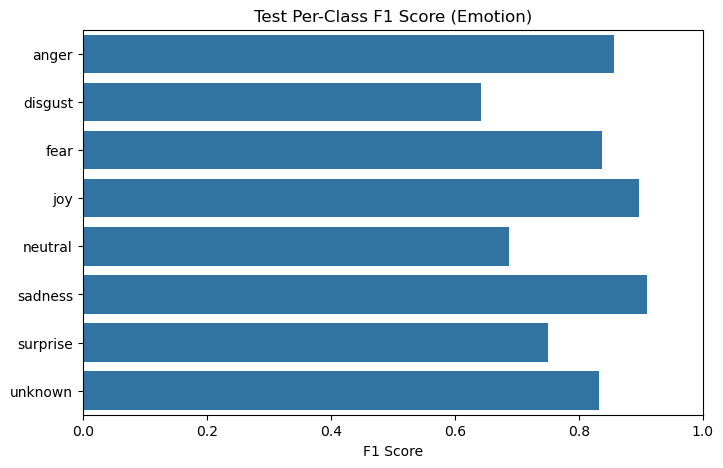

F1 bar plot... done


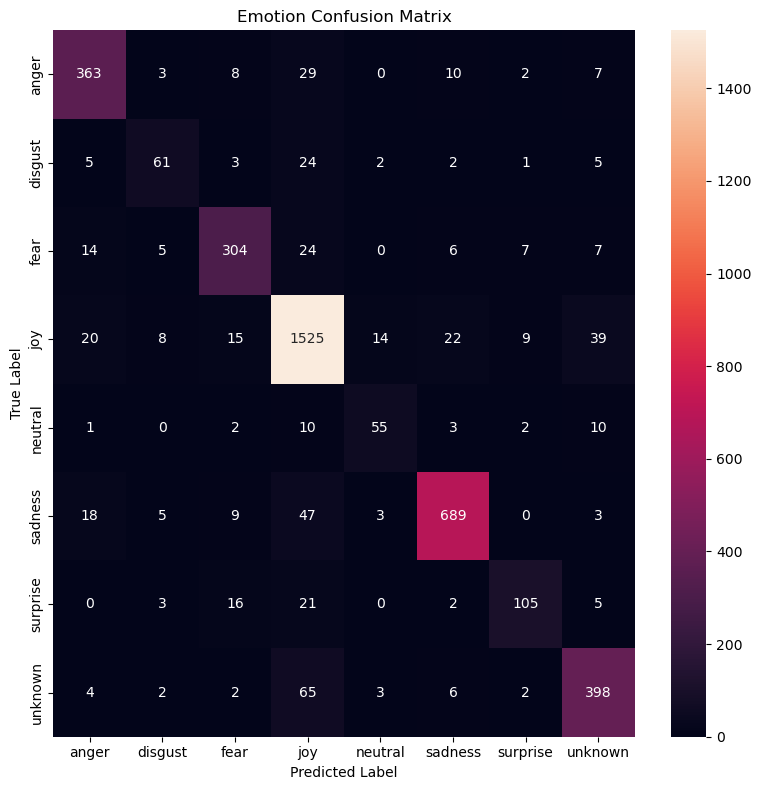

Confusion matrix... done

==== Emotion Classification Report ====
              precision    recall  f1-score   support

       anger       0.85      0.86      0.86       422
     disgust       0.70      0.59      0.64       103
        fear       0.85      0.83      0.84       367
         joy       0.87      0.92      0.90      1652
     neutral       0.71      0.66      0.69        83
     sadness       0.93      0.89      0.91       774
    surprise       0.82      0.69      0.75       152
     unknown       0.84      0.83      0.83       482

    accuracy                           0.87      4035
   macro avg       0.82      0.78      0.80      4035
weighted avg       0.87      0.87      0.87      4035

Test Macro F1 (Emotion): 0.8018590554821968
Test Accuracy (Emotion): 0.8674101610904585

==== Intent Classification Report ====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.33      1.00      0.50   

C:\Users\Shristi chandra\.conda\envs\mhc_gpu\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Shristi chandra\.conda\envs\mhc_gpu\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Shristi chandra\.conda\envs\mhc_gpu\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [28]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from transformers import DistilBertModel

PIPELINE_DIR = r"C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT\data\harmonized_pipeline"
MODEL_DIR = r"C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT\models"

# Load split and patch columns
test_df = pd.read_pickle(fr"{PIPELINE_DIR}\test.pkl")
print("Loaded test split... done")
if "harmonized_emotion_id" not in test_df.columns and "harmonized_emotion" in test_df.columns:
    test_df["harmonized_emotion_id"] = pd.Categorical(test_df["harmonized_emotion"]).codes
if "intent_id" not in test_df.columns and "intent" in test_df.columns:
    test_df["intent_id"] = pd.Categorical(test_df["intent"]).codes
print("Column check/patch... done")

print("harmonized_emotion_id unique:", test_df["harmonized_emotion_id"].nunique())
print("intent_id unique:", test_df["intent_id"].nunique())

class MultiTaskDataset(Dataset):
    def __init__(self, df):
        self.input_ids = df["input_ids"].values
        self.attention_mask = df["attention_mask"].values
        self.emotion_labels = df["harmonized_emotion_id"].values
        self.intent_labels = df["intent_id"].values
    def __len__(self): return len(self.input_ids)
    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx], dtype=torch.long),
            "attention_mask": torch.tensor(self.attention_mask[idx], dtype=torch.long),
            "emotion_labels": torch.tensor(self.emotion_labels[idx], dtype=torch.long),
            "intent_labels": torch.tensor(self.intent_labels[idx], dtype=torch.long),
        }
def collate_fn(batch): return {k: torch.stack([x[k] for x in batch]) for k in batch[0]}

test_loader = DataLoader(MultiTaskDataset(test_df), batch_size=32, shuffle=False, collate_fn=collate_fn)
print("Test DataLoader... done")

# MODEL SETUP
num_emotions = test_df["harmonized_emotion_id"].max() + 1
num_intents = test_df["intent_id"].max() + 1
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Preparing model with classes: emotions={num_emotions}, intents={num_intents} ... done")

class DistilBERTMTL(nn.Module):
    def __init__(self, model_name, num_emotions, num_intents):
        super().__init__()
        self.encoder = DistilBertModel.from_pretrained(model_name)
        h_size = self.encoder.config.hidden_size
        self.emotion_classifier = nn.Linear(h_size, num_emotions)
        self.intent_classifier = nn.Linear(h_size, num_intents)
    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]
        return self.emotion_classifier(pooled), self.intent_classifier(pooled)

model = DistilBERTMTL("distilbert-base-uncased", num_emotions, num_intents).to(device)
print("Model created... done")
model.load_state_dict(torch.load(fr"{MODEL_DIR}\best_mtl_model.pt", map_location=device))
model.eval()
print("Model state_dict loaded and ready... done")

label_names = list(pd.Categorical(test_df["harmonized_emotion"]).categories)

# PREDICTION/EVALUATION BLOCK
all_targets_e, all_preds_e = [], []
all_targets_i, all_preds_i = [], []

with torch.no_grad():
    for batch in test_loader:
        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        em_labels = batch["emotion_labels"].cpu().numpy()
        in_labels = batch["intent_labels"].cpu().numpy()
        em_logits, in_logits = model(ids, mask)
        em_pred = torch.argmax(em_logits, 1).cpu().numpy()
        in_pred = torch.argmax(in_logits, 1).cpu().numpy()
        all_targets_e.extend(em_labels)
        all_preds_e.extend(em_pred)
        all_targets_i.extend(in_labels)
        all_preds_i.extend(in_pred)
print("Predictions complete... done")

# Per-class F1 Bar Plot
report = classification_report(all_targets_e, all_preds_e, target_names=label_names, output_dict=True)
emotion_f1s = [report[l]['f1-score'] for l in label_names]
plt.figure(figsize=(8,5))
sns.barplot(y=label_names, x=emotion_f1s)
plt.title("Test Per-Class F1 Score (Emotion)")
plt.xlabel("F1 Score")
plt.xlim(0, 1)
plt.show()
print("F1 bar plot... done")

# Pretty Confusion Matrix
cm = confusion_matrix(all_targets_e, all_preds_e)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Emotion Confusion Matrix')
plt.tight_layout()
plt.show()
print("Confusion matrix... done")

# Detailed Classification Report
print("\n==== Emotion Classification Report ====")
print(classification_report(all_targets_e, all_preds_e, target_names=label_names))
print("Test Macro F1 (Emotion):", f1_score(all_targets_e, all_preds_e, average="macro"))
print("Test Accuracy (Emotion):", accuracy_score(all_targets_e, all_preds_e))

print("\n==== Intent Classification Report ====")
print(classification_report(all_targets_i, all_preds_i))
print("Test Macro F1 (Intent):", f1_score(all_targets_i, all_preds_i, average="macro"))
print("Test Accuracy (Intent):", accuracy_score(all_targets_i, all_preds_i))
print("All metric reports... done")


In [30]:
!pip install tabulate


In [31]:
import pandas as pd

emotion_f1 = 0.8019
emotion_acc = 0.8674
intent_f1 = 0.3249
intent_acc = 0.7271

results = {
    "Task": ["Emotion", "Intent"],
    "Macro F1": [emotion_f1, intent_f1],
    "Accuracy": [emotion_acc, intent_acc]
}
df_summary = pd.DataFrame(results)

# Print as plain table (this works in any Python environment)
print(df_summary)

# Or export to CSV if you want:
df_summary.to_csv("results_summary.csv", index=False)


      Task  Macro F1  Accuracy
0  Emotion    0.8019    0.8674
1   Intent    0.3249    0.7271


Emotion/Intent classes loaded... done 8 5667


C:\Users\Shristi chandra\AppData\Local\Temp\ipykernel_1940\2647846857.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(MODE

✅ Trained model loaded successfully...
🧩 Unknown-label rows found: 24770
📦 DataLoader for pseudo-labeling prepared...
✅ High-confidence pseudo-labels saved successfully at:
C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT\data\pseudo_labels\pseudo_labeled.csv


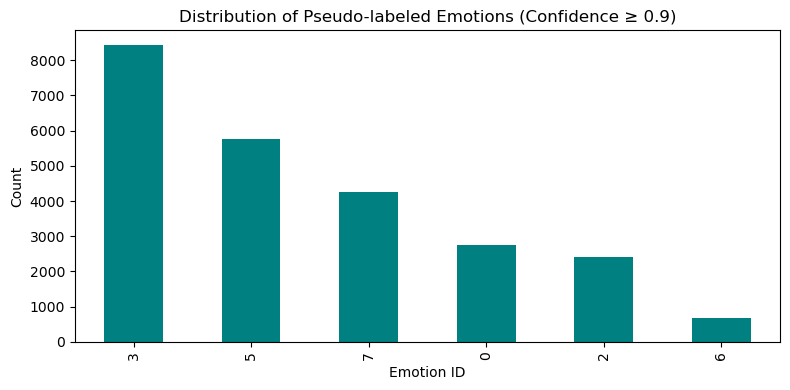

🎯 Pseudo-labeling process completed.


In [47]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertModel
import torch.nn as nn
import matplotlib.pyplot as plt

PROJECT_ROOT = r"C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT"
PIPELINE_DIR = os.path.join(PROJECT_ROOT, "data", "harmonized_pipeline")
TOKENIZED_PATH = os.path.join(PIPELINE_DIR, "tokenized_harmonized.pkl")
MODEL_DIR = os.path.join(PROJECT_ROOT, "models")
PSEUDO_SAVE = os.path.join(PROJECT_ROOT, "data", "pseudo_labels", "pseudo_labeled.csv")
os.makedirs(os.path.dirname(PSEUDO_SAVE), exist_ok=True)

num_emotions = 8
num_intents = 5667
print("Emotion/Intent classes loaded... done", num_emotions, num_intents)

class DistilBERTMTL(nn.Module):
    def __init__(self, model_name, num_emotions, num_intents, dropout=0.3):
        super().__init__()
        self.encoder = DistilBertModel.from_pretrained(model_name)
        h_size = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        self.emotion_classifier = nn.Linear(h_size, num_emotions)
        self.intent_classifier = nn.Linear(h_size, num_intents)
    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.dropout(outputs.last_hidden_state[:, 0])
        return self.emotion_classifier(pooled), self.intent_classifier(pooled)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = DistilBERTMTL("distilbert-base-uncased", num_emotions, num_intents).to(device)
model.load_state_dict(torch.load(os.path.join(MODEL_DIR, "best_mtl_model.pt"), map_location=device))
model.eval()
print("✅ Trained model loaded successfully...")

corpus = pd.read_pickle(TOKENIZED_PATH)
if "harmonized_emotion" in corpus:
    mask_emotion = (corpus["harmonized_emotion"] == "unknown")
else:
    mask_emotion = (corpus["emotion"] == "unknown")
mask_intent = (corpus["intent"] == "unknown")
pseudo_df = corpus[mask_emotion | mask_intent].copy()
print(f"🧩 Unknown-label rows found: {len(pseudo_df)}")

class PseudoLabelDataset(Dataset):
    def __init__(self, df):
        self.input_ids = df["input_ids"].tolist()
        self.attention_mask = df["attention_mask"].tolist()
    def __len__(self): return len(self.input_ids)
    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx], dtype=torch.long),
            "attention_mask": torch.tensor(self.attention_mask[idx], dtype=torch.long),
        }

def collate_fn(batch):
    return {k: torch.stack([x[k] for x in batch]) for k in batch[0]}

pseudo_loader = DataLoader(PseudoLabelDataset(pseudo_df), batch_size=32, shuffle=False, collate_fn=collate_fn)
print("📦 DataLoader for pseudo-labeling prepared...")

emotion_pseudo, intent_pseudo, conf_em, conf_in = [], [], [], []
with torch.no_grad():
    for batch in pseudo_loader:
        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        logits_em, logits_in = model(ids, mask)
        prob_em = torch.softmax(logits_em, -1)
        prob_in = torch.softmax(logits_in, -1)
        top_p_em, pred_em = prob_em.max(1)
        top_p_in, pred_in = prob_in.max(1)
        emotion_pseudo.extend(pred_em.cpu().numpy())
        intent_pseudo.extend(pred_in.cpu().numpy())
        conf_em.extend(top_p_em.cpu().numpy())
        conf_in.extend(top_p_in.cpu().numpy())

pseudo_df["pseudo_emotion_id"] = emotion_pseudo
pseudo_df["pseudo_intent_id"] = intent_pseudo
pseudo_df["conf_em"] = conf_em
pseudo_df["conf_in"] = conf_in

pseudo_high = pseudo_df[(pseudo_df.conf_em >= 0.9) | (pseudo_df.conf_in >= 0.9)].copy()
pseudo_high["is_pseudo"] = True
pseudo_high.to_csv(PSEUDO_SAVE, index=False)
print(f"✅ High-confidence pseudo-labels saved successfully at:\n{PSEUDO_SAVE}")

plt.figure(figsize=(8, 4))
pseudo_high["pseudo_emotion_id"].value_counts().plot(kind="bar", color="teal")
plt.title("Distribution of Pseudo-labeled Emotions (Confidence ≥ 0.9)")
plt.xlabel("Emotion ID")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print("🎯 Pseudo-labeling process completed.")


In [50]:

import os
import pandas as pd

PROJECT_ROOT = r"C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT"
PIPELINE_DIR = os.path.join(PROJECT_ROOT, "data", "harmonized_pipeline")
PSEUDO_PATH = os.path.join(PROJECT_ROOT, "data", "pseudo_labels", "pseudo_labeled.csv")
TRAIN_PATH = os.path.join(PIPELINE_DIR, "train.pkl")
SEMI_TRAIN_PATH = os.path.join(PIPELINE_DIR, "train_semisup.pkl")

# Load gold and pseudo-labeled data
train_gold = pd.read_pickle(TRAIN_PATH)
pseudo = pd.read_csv(PSEUDO_PATH)

# Harmonize pseudo-labeled dataframe columns
pseudo = pseudo.rename(columns={
    "pseudo_emotion_id": "harmonized_emotion_id",
    "pseudo_intent_id": "intent_id"
})

# Select only necessary columns
columns_needed = ["input_ids", "attention_mask", "harmonized_emotion_id", "intent_id"]
pseudo = pseudo[columns_needed]

# Ensure dtypes match
pseudo = pseudo.astype(train_gold[columns_needed].dtypes.to_dict())

# Reset index to avoid duplicate indices
train_gold = train_gold.reset_index(drop=True)
pseudo = pseudo.reset_index(drop=True)

# Check for duplicated columns and drop if any
train_gold = train_gold.loc[:, ~train_gold.columns.duplicated()]
pseudo = pseudo.loc[:, ~pseudo.columns.duplicated()]

# Concatenate and shuffle
aug_train = pd.concat([train_gold, pseudo], ignore_index=True)
aug_train = aug_train.sample(frac=1, random_state=42).reset_index(drop=True)
aug_train.to_pickle(SEMI_TRAIN_PATH)
print(f"✅ Semi-supervised train set saved at: {SEMI_TRAIN_PATH}")


✅ Semi-supervised train set saved at: C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT\data\harmonized_pipeline\train_semisup.pkl


In [5]:
import os
import ast
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel
import torch.nn as nn
from torch.optim import AdamW
from sklearn.metrics import f1_score
import gc

print("Starting script...", flush=True)

PROJECT_ROOT = r"C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT"
PIPELINE_DIR = os.path.join(PROJECT_ROOT, "data", "harmonized_pipeline")
SEMI_TRAIN_PATH = os.path.join(PIPELINE_DIR, "train_semisup.pkl")
VAL_PATH = os.path.join(PIPELINE_DIR, "val.pkl")
MODEL_DIR = os.path.join(PROJECT_ROOT, "models")
os.makedirs(MODEL_DIR, exist_ok=True)

print("Clearing GPU and CPU cache...", flush=True)
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()
print("Cache cleared.", flush=True)

def ensure_list(val):
    if isinstance(val, list): return val
    if isinstance(val, str):
        trimmed = val.strip()
        if trimmed.startswith("[") and trimmed.endswith("]"):
            content = trimmed[1:-1].strip()
            if "," not in content and " " in content:
                return [int(x) for x in content.split() if x]
            try: return ast.literal_eval(val)
            except Exception: pass
        return [int(x) for x in trimmed.split() if x]
    return val

def contiguous_map(col):
    uniques = sorted(col.unique())
    mapping = {old: new for new, old in enumerate(uniques)}
    return col.map(mapping).astype(int), mapping

print("Loading datasets...", flush=True)
train_df = pd.read_pickle(SEMI_TRAIN_PATH)
val_df = pd.read_pickle(VAL_PATH)

print(f"Train dataset loaded. Size: {len(train_df)}", flush=True)
print(f"Validation dataset loaded. Size: {len(val_df)}", flush=True)

for col in ["input_ids", "attention_mask"]:
    train_df[col] = train_df[col].apply(ensure_list)
    val_df[col] = val_df[col].apply(ensure_list)

train_df["emotion_labels"], emo_map = contiguous_map(train_df["harmonized_emotion_id"])
train_df["intent_labels"], int_map = contiguous_map(train_df["intent_id"])
val_df["emotion_labels"] = val_df["harmonized_emotion_id"].map(emo_map).fillna(-100).astype(int)
val_df["intent_labels"] = val_df["intent_id"].map(int_map).fillna(-100).astype(int)

class MultiTaskDataset(Dataset):
    def __init__(self, df):
        self.input_ids = df["input_ids"].tolist()
        self.attention_mask = df["attention_mask"].tolist()
        self.emotion_labels = df["emotion_labels"].values
        self.intent_labels = df["intent_labels"].values
    def __len__(self):
        return len(self.input_ids)
    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx], dtype=torch.long),
            "attention_mask": torch.tensor(self.attention_mask[idx], dtype=torch.long),
            "emotion_labels": torch.tensor(self.emotion_labels[idx], dtype=torch.long),
            "intent_labels": torch.tensor(self.intent_labels[idx], dtype=torch.long),
        }

def collate_fn(batch):
    return {k: torch.stack([x[k] for x in batch]) for k in batch[0]}

train_dataset = MultiTaskDataset(train_df)
val_dataset = MultiTaskDataset(val_df)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

print(f"Train dataset size: {len(train_dataset)}", flush=True)
print(f"Validation dataset size: {len(val_dataset)}", flush=True)
print(f"Train DataLoader batches: {len(train_loader)}", flush=True)
print(f"Val DataLoader batches: {len(val_loader)}", flush=True)

num_emotions = train_df["emotion_labels"].nunique()
num_intents = train_df["intent_labels"].nunique()

print(f"Number of emotion classes: {num_emotions}", flush=True)
print(f"Number of intent classes: {num_intents}", flush=True)

class DistilBERTMTL(nn.Module):
    def __init__(self, model_name, num_emotions, num_intents, dropout=0.3):
        super().__init__()
        self.encoder = DistilBertModel.from_pretrained(model_name)
        h_size = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        self.emotion_classifier = nn.Linear(h_size, num_emotions)
        self.intent_classifier = nn.Linear(h_size, num_intents)
    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.dropout(outputs.last_hidden_state[:, 0])
        return self.emotion_classifier(pooled), self.intent_classifier(pooled)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}", flush=True)
model = DistilBERTMTL("distilbert-base-uncased", num_emotions, num_intents).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion_em = nn.CrossEntropyLoss(ignore_index=-100)
criterion_in = nn.CrossEntropyLoss(ignore_index=-100)

def train_epoch(model, loader, optimizer, criterion_em, criterion_in):
    model.train()
    total_loss = 0
    for i, batch in enumerate(loader):
        if i % 10 == 0:
            print(f"Training batch {i+1}/{len(loader)}", flush=True)
        optimizer.zero_grad()
        ids = batch["input_ids"].to(device)
        masks = batch["attention_mask"].to(device)
        em_lab = batch["emotion_labels"].to(device)
        in_lab = batch["intent_labels"].to(device)
        out_em, out_in = model(ids, masks)
        loss = 0.5 * criterion_em(out_em, em_lab) + 0.5 * criterion_in(out_in, in_lab)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def eval_epoch(model, loader, criterion_em, criterion_in):
    model.eval()
    total_loss = 0
    all_preds_e, all_true_e, all_preds_i, all_true_i = [], [], [], []
    with torch.no_grad():
        for i, batch in enumerate(loader):
            if i % 10 == 0:
                print(f"Evaluating batch {i+1}/{len(loader)}", flush=True)
            ids = batch["input_ids"].to(device)
            masks = batch["attention_mask"].to(device)
            em_lab = batch["emotion_labels"].to(device)
            in_lab = batch["intent_labels"].to(device)
            out_em, out_in = model(ids, masks)
            loss = 0.5 * criterion_em(out_em, em_lab) + 0.5 * criterion_in(out_in, in_lab)
            total_loss += loss.item()
            all_preds_e.extend(torch.argmax(out_em, dim=1).cpu().tolist())
            all_true_e.extend(em_lab.cpu().tolist())
            all_preds_i.extend(torch.argmax(out_in, dim=1).cpu().tolist())
            all_true_i.extend(in_lab.cpu().tolist())
    f1_em = f1_score(all_true_e, all_preds_e, average="macro", zero_division=0)
    f1_in = f1_score(all_true_i, all_preds_i, average="macro", zero_division=0)
    return total_loss / len(loader), f1_em, f1_in

epochs = 15
patience_limit = 3
checkpoint_path = os.path.join(MODEL_DIR, "best_mtl_model_semisup.pt")
optimizer_path = os.path.join(MODEL_DIR, "optimizer_state.pt")
epoch_path = os.path.join(MODEL_DIR, "last_epoch.txt")

best_f1 = 0
best_val_loss = float("inf")
patience = 0
start_epoch = 1

if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print(f"Loaded model weights from: {checkpoint_path}", flush=True)

if os.path.exists(optimizer_path):
    optimizer.load_state_dict(torch.load(optimizer_path, map_location=device))
    print(f"Loaded optimizer state from: {optimizer_path}", flush=True)

if os.path.exists(epoch_path):
    with open(epoch_path, 'r') as ef:
        start_epoch = int(ef.read()) + 1
    print(f"Resuming training from epoch {start_epoch}", flush=True)

for epoch in range(start_epoch, epochs + 1):
    print(f"\nStarting epoch {epoch}/{epochs}...", flush=True)
    train_loss = train_epoch(model, train_loader, optimizer, criterion_em, criterion_in)
    val_loss, val_f1_em, val_f1_in = eval_epoch(model, val_loader, criterion_em, criterion_in)
    avg_f1 = (val_f1_em + val_f1_in) / 2

    print(f"Epoch {epoch}/{epochs} Results:", flush=True)
    print(f"Train Loss: {train_loss:.4f}", flush=True)
    print(f"Val Loss: {val_loss:.4f}", flush=True)
    print(f"Val F1 Emotion: {val_f1_em:.4f}", flush=True)
    print(f"Val F1 Intent: {val_f1_in:.4f}", flush=True)
    print(f"Average F1: {avg_f1:.4f}", flush=True)

    improved = False
    if avg_f1 > best_f1:
        best_f1 = avg_f1
        torch.save(model.state_dict(), checkpoint_path)
        torch.save(optimizer.state_dict(), optimizer_path)
        with open(epoch_path, 'w') as ef:
            ef.write(str(epoch))
        print("Model improved — checkpoint saved.", flush=True)
        patience = 0
        improved = True
    if val_loss < best_val_loss and not improved:
        best_val_loss = val_loss
        patience = 0
        print("Validation loss improved (no F1 gain) — patience reset.", flush=True)
    elif not improved:
        patience += 1
        print(f"No improvement this epoch. Patience = {patience}", flush=True)

    if patience >= patience_limit:
        print("\nEarly stopping triggered — training stopped to prevent overfitting.", flush=True)
        break

print("\nTraining completed successfully.", flush=True)
print(f"Best validation F1 achieved: {best_f1:.4f}", flush=True)


Starting script...
Clearing GPU and CPU cache...
Cache cleared.
Loading datasets...
Train dataset loaded. Size: 56540
Validation dataset loaded. Size: 4034
Train dataset size: 56540
Validation dataset size: 4034
Train DataLoader batches: 3534
Val DataLoader batches: 253
Number of emotion classes: 8
Number of intent classes: 5063
Using device: cuda


C:\Users\Shristi chandra\AppData\Local\Temp\ipykernel_4712\2651823371.py:170: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path,

Loaded model weights from: C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT\models\best_mtl_model_semisup.pt


C:\Users\Shristi chandra\AppData\Local\Temp\ipykernel_4712\2651823371.py:174: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  optimizer.load_state_dict(torch.load(optimizer_pa

Loaded optimizer state from: C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT\models\optimizer_state.pt
Resuming training from epoch 8

Starting epoch 8/15...
Training batch 1/3534
Training batch 11/3534
Training batch 21/3534
Training batch 31/3534
Training batch 41/3534
Training batch 51/3534
Training batch 61/3534
Training batch 71/3534
Training batch 81/3534
Training batch 91/3534
Training batch 101/3534
Training batch 111/3534
Training batch 121/3534
Training batch 131/3534
Training batch 141/3534
Training batch 151/3534
Training batch 161/3534
Training batch 171/3534
Training batch 181/3534
Training batch 191/3534
Training batch 201/3534
Training batch 211/3534
Training batch 221/3534
Training batch 231/3534
Training batch 241/3534
Training batch 251/3534
Training batch 261/3534
Training batch 271/3534
Training batch 281/3534
Training batch 291/3534
Training batch 301/3534
Training batch 311/3534
Training batch 321/3534
Training batch 331/3534
Training batch 341/3

Emotion Accuracy: 0.8902
Emotion Macro F1: 0.8431
Emotion Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.90       422
           1       0.74      0.59      0.66       103
           2       0.88      0.88      0.88       367
           3       0.90      0.91      0.90      1652
           4       0.85      0.70      0.77        83
           5       0.94      0.93      0.93       774
           6       0.87      0.83      0.85       152
           7       0.82      0.90      0.86       482

    accuracy                           0.89      4035
   macro avg       0.87      0.83      0.84      4035
weighted avg       0.89      0.89      0.89      4035



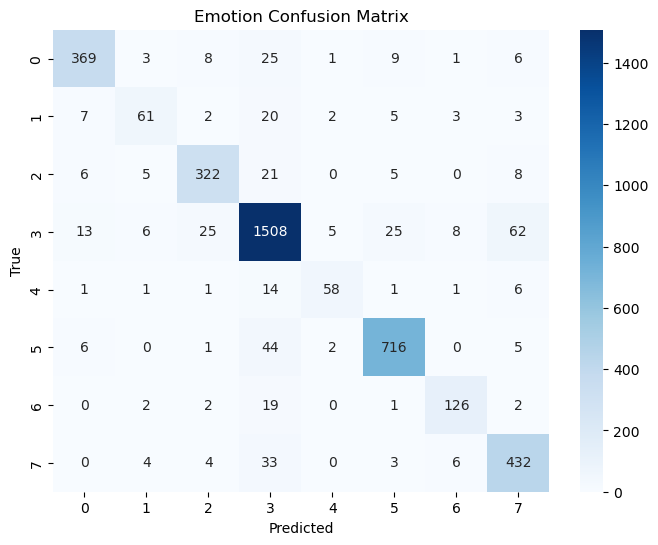

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for valid predictions (if needed)
filtered_e = [(t, p) for t, p in zip(all_true_e, all_pred_e) if t != -100]
true_e, pred_e = zip(*filtered_e) if filtered_e else ([], [])

# Unique emotion labels
unique_emotion_labels = sorted(set(true_e) | set(pred_e))
target_names_emo = [idx2emo[i] for i in unique_emotion_labels]

# Metrics and report
emotion_accuracy = accuracy_score(true_e, pred_e)
emotion_macro_f1 = f1_score(true_e, pred_e, average="macro", zero_division=0)

print(f"Emotion Accuracy: {emotion_accuracy:.4f}")
print(f"Emotion Macro F1: {emotion_macro_f1:.4f}")

print("Emotion Classification Report:")
print(classification_report(
    true_e, pred_e,
    labels=unique_emotion_labels,
    target_names=target_names_emo,
    zero_division=0
))

cm_em = confusion_matrix(true_e, pred_e, labels=unique_emotion_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_em, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names_emo, yticklabels=target_names_emo)
plt.title("Emotion Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Intent Accuracy: 0.8556
Intent Macro F1: 0.6207
Intent Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           4       0.50      1.00      0.67         1
           7       1.00      1.00      1.00         2
           9       0.60      1.00      0.75         3
          15       1.00      1.00      1.00         2
          16       0.83      0.71      0.77         7
          19       1.00      1.00      1.00         1
          22       1.00      1.00      1.00         1
          23       0.00      0.00      0.00         1
          25       0.00      0.00      0.00         3
          35       0.67      1.00      0.80         2
          37       0.00      0.00      0.00         1
          39       0.00      0.00      0.00         0
          40       1.00      1.00      1.00         2
          41       0.00      0.00      0.00         0
   

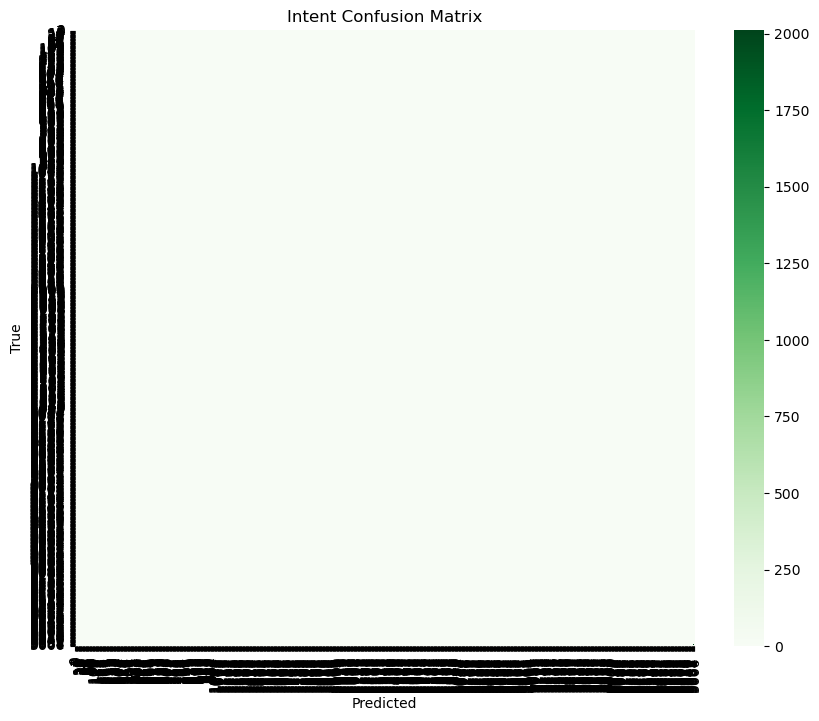

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for valid predictions (if needed)
filtered_i = [(t, p) for t, p in zip(all_true_i, all_pred_i) if t != -100]
true_i, pred_i = zip(*filtered_i) if filtered_i else ([], [])

# Unique intent labels
unique_intent_labels = sorted(set(true_i) | set(pred_i))
target_names_int = [idx2intent[i] for i in unique_intent_labels]

# Metrics and report
intent_accuracy = accuracy_score(true_i, pred_i)
intent_macro_f1 = f1_score(true_i, pred_i, average="macro", zero_division=0)

print(f"Intent Accuracy: {intent_accuracy:.4f}")
print(f"Intent Macro F1: {intent_macro_f1:.4f}")

print("Intent Classification Report:")
print(classification_report(
    true_i, pred_i,
    labels=unique_intent_labels,
    target_names=target_names_int,
    zero_division=0
))

cm_in = confusion_matrix(true_i, pred_i, labels=unique_intent_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_in, annot=False, fmt='d', cmap='Greens',
            xticklabels=target_names_int, yticklabels=target_names_int)
plt.title("Intent Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [13]:
from IPython.display import display, Markdown

# Assuming emotion_accuracy, emotion_macro_f1, intent_accuracy, intent_macro_f1 are computed

table_md = f"""
| Task    | Accuracy | Macro F1 |
|---------|----------|----------|
| Emotion | {emotion_accuracy:.4f}   | {emotion_macro_f1:.4f}   |
| Intent  | {intent_accuracy:.4f}   | {intent_macro_f1:.4f}   |
"""

display(Markdown(table_md))



| Task    | Accuracy | Macro F1 |
|---------|----------|----------|
| Emotion | 0.8902   | 0.8431   |
| Intent  | 0.8556   | 0.6207   |


In [ ]:
#chat BOT + ethics and privacy:---

In [22]:
pip install torch transformers gradio pandas numpy

Note: you may need to restart the kernel to use updated packages.


In [26]:
pip install transformers torch gradio sentencepiece

   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 10.2 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [22]:
import os
import json
import re
import string
import torch
import numpy as np
from transformers import DistilBertTokenizerFast
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from collections import defaultdict

# ==============================================================================
# 1. Configuration and Asset Loading (Crucial: Update Paths!)
# ==============================================================================

# NOTE: Update this path to where your project data and model files are located.
PROJECT_ROOT = r"C:\Users\Shristi chandra\OneDrive\Desktop\Mental_Health_Chat-BOT"

# Directories from your project structure
TOKENIZED_DIR = os.path.join(PROJECT_ROOT, "data", "tokenized")
MODEL_DIR = os.path.join(PROJECT_ROOT, "model_checkpoints") # Assumed path for saved model

# File names
MODEL_FILE = os.path.join(MODEL_DIR, "best_mtl_model.pt") # The best saved model checkpoint
EMOTION_MAP_FILE = os.path.join(TOKENIZED_DIR, "emotion2id.json")
INTENT_MAP_FILE = os.path.join(TOKENIZED_DIR, "intent2id.json")

# Model parameters
MAX_SEQ_LENGTH = 64 # Must match the length used during training
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==============================================================================
# 2. Text Preprocessing Utility (Must match training preprocessing)
# ==============================================================================

def clean_text(text: str, keep_emojis=False) -> str:
    """Applies the same cleaning steps used in your Step 2 pipeline."""
    if not isinstance(text, str):
        return ""
    
    # Lowercase
    text = text.lower()
    
    # Mask PII (as per your training logic)
    text = re.sub(r'[\w\.-]+@[\w\.-]+', '<EMAIL>', text)  # Emails
    text = re.sub(r'(http|ftp)s?://\S+', '<URL>', text)  # URLs
    text = re.sub(r'\d+', '<NUM>', text)  # Numbers
    text = re.sub(r'@\w+', '<USER>', text) # User handles
    
    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    
    # Remove extra whitespace
    text = re.sub(' +', ' ', text).strip()
    
    return text

# ==============================================================================
# 3. Model Architecture (Must match your training script's model definition)
# ==============================================================================

from transformers import DistilBertModel

class MultiTaskModel(torch.nn.Module):
    """
    A simplified representation of your Multi-Task DistilBERT Model
    based on the description.
    """
    def __init__(self, num_emotion_labels, num_intent_labels):
        super(MultiTaskModel, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = torch.nn.Dropout(0.1)
        
        # Output layers for each task
        self.emotion_classifier = torch.nn.Linear(self.distilbert.config.dim, num_emotion_labels)
        self.intent_classifier = torch.nn.Linear(self.distilbert.config.dim, num_intent_labels)

    def forward(self, input_ids, attention_mask):
        # DistilBERT outputs (last hidden state is the first element)
        output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output[0][:, 0, :] # Use the [CLS] token's hidden state
        
        # Apply dropout
        pooled_output = self.dropout(hidden_state)
        
        # Predict for each task
        emotion_logits = self.emotion_classifier(pooled_output)
        intent_logits = self.intent_classifier(pooled_output)
        
        return emotion_logits, intent_logits

# ==============================================================================
# 4. Chatbot Inference and Logic Class
# ==============================================================================

class MentalHealthChatbot:
    def __init__(self):
        # Load label mappings
        with open(EMOTION_MAP_FILE, 'r') as f:
            self.emotion2id = json.load(f)
        with open(INTENT_MAP_FILE, 'r') as f:
            self.intent2id = json.load(f)
        
        self.id2emotion = {v: k for k, v in self.emotion2id.items()}
        self.id2intent = {v: k for k, v in self.intent2id.items()}
        
        # Load Tokenizer
        self.tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
        
        # Initialize and load model
        num_emotions = len(self.emotion2id)
        num_intents = len(self.intent2id)
        
        self.model = MultiTaskModel(num_emotions, num_intents)
        self.model.load_state_dict(torch.load(MODEL_FILE, map_location=DEVICE))
        self.model.to(DEVICE)
        self.model.eval()
        
        # Initialize conversation history for context (Dynamic Element)
        self.history = []

    def _predict(self, text):
        """Internal function to get emotion and intent predictions."""
        # Preprocess text
        cleaned_text = clean_text(text)
        
        # Tokenize
        inputs = self.tokenizer(
            cleaned_text,
            max_length=MAX_SEQ_LENGTH,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        
        # Move inputs to device
        input_ids = inputs['input_ids'].to(DEVICE)
        attention_mask = inputs['attention_mask'].to(DEVICE)
        
        # Get predictions
        with torch.no_grad():
            emotion_logits, intent_logits = self.model(input_ids, attention_mask)

        # Get the predicted IDs
        pred_emotion_id = torch.argmax(emotion_logits, dim=1).item()
        pred_intent_id = torch.argmax(intent_logits, dim=1).item()
        
        # Convert IDs back to labels
        emotion = self.id2emotion[pred_emotion_id]
        intent = self.id2intent[pred_intent_id]
        
        return emotion, intent

    # --- KNOWLEDGE BASE (Dynamic Response Generator) ---
    # This is a sample KB. You will need to expand this with therapeutic content.
    def _get_response_from_kb(self, emotion: str, intent: str, history: list) -> str:
        """
        Dynamic response generation based on emotion, intent, and history.
        The most dynamic part of the chatbot.
        """
        # --- Crisis Protocol: Highest Priority ---
        crisis_keywords = ["kill myself", "suicide", "end my life", "i can't go on", "help me now"]
        if any(keyword in history[-1][0].lower() for keyword in crisis_keywords) or emotion == 'fear' and intent == 'need_help':
            return (
                "🛑 I hear you and your safety is the most important thing. I am an AI, "
                "not a substitute for a human crisis counselor. Please contact one of these resources immediately: "
                "**National Suicide Prevention Lifeline: 988** (US/Canada). **Crisis Text Line:** Text **HOME** to 741741. "
                "You are not alone."
            )

        # --- Dynamic Logic based on Emotion and Intent ---
        
        response_map = {
            # Emotion: Sadness
            'sadness': {
                'greeting': "Thank you for reaching out. It sounds like you're carrying some sadness right now. I'm here to listen, what's on your mind?",
                'need_help': "I see that you're feeling down and need support. Can you describe what the hardest part of your day was?",
                'venting': "It's okay to feel this way. Just let it all out. I'm listening without judgment. Is there anything specific you want to vent about?",
                'asking_for_advice': "I understand you need some direction. When you feel sad, what's one small thing that usually brings you comfort?",
                'default': "It's okay to feel sad. Please take a deep breath. What would you like to talk about next?"
            },
            # Emotion: Joy
            'joy': {
                'greeting': "That's wonderful! I can sense your joy. What brought on this great mood today?",
                'sharing_feeling': "I love hearing good news! Please share more about what made you feel so happy!",
                'default': "Keep that positive energy going! How can I support you further today?"
            },
            # Emotion: Anxiety/Fear
            'anxiety': {
                'need_help': "I hear that anxiety. Let's try to focus on the present. Can you name 5 things you can see right now?",
                'asking_for_advice': "Dealing with anxiety is difficult, but you're being proactive. We can try a grounding technique or a simple breathing exercise. Which would you prefer?"
            },
            # Default fallback for other intents/emotions
            'default': {
                'default': f"I detected the emotion **{emotion}** and the intent **{intent}**. How about we explore that a little more? What's the first step you'd like to take?"
            }
        }
        
        # Select response based on the detected emotion and intent
        # Default to a general response if the specific (emotion, intent) pair is not defined
        
        emotion_responses = response_map.get(emotion, response_map['default'])
        response = emotion_responses.get(intent, emotion_responses.get('default', response_map['default']['default']))

        return response
        
    def chat(self, user_input: str) -> str:
        """The main conversation loop for the chatbot."""
        
        # 1. Prediction
        emotion, intent = self._predict(user_input)
        
        # 2. Update History: Store (user_input, emotion, intent)
        # We only store the last few turns to manage complexity
        self.history.append((user_input, emotion, intent))
        self.history = self.history[-10:] # Keep last 10 turns
        
        # 3. Response Generation (using the dynamic KB)
        response = self._get_response_from_kb(emotion, intent, self.history)
        
        # 4. Return response to user
        return response

# ==============================================================================
# 5. Simple Command-Line Interface (CLI) for Testing
# ==============================================================================

if __name__ == "__main__":
    try:
        print("Initializing Mental Health Chatbot...")
        # NOTE: This will fail if your model and mapping files are not in the paths defined at the top.
        bot = MentalHealthChatbot()
        print(f"Bot initialized on {DEVICE}. Start chatting.")
        print("-" * 40)
        
        while True:
            user_input = input("You: ")
            if user_input.lower() in ["quit", "exit", "stop"]:
                print("Bot: Goodbye! Remember to reach out if you need support.")
                break
            
            # Get response from the dynamic chatbot core
            bot_response = bot.chat(user_input)
            print(f"Bot: {bot_response}")
            
    except FileNotFoundError as e:
        print(f"\n[ERROR] One or more required files were not found.")
        print(f"Please check the PROJECT_ROOT and MODEL_FILE paths.")
        print(f"Missing file: {e}")
    except Exception as e:
        print(f"\n[CRITICAL ERROR] An unexpected error occurred: {e}")

Initializing Mental Health Chatbot...

[ERROR] One or more required files were not found.
Please check the PROJECT_ROOT and MODEL_FILE paths.
Missing file: [Errno 2] No such file or directory: 'C:\\Users\\Shristi chandra\\OneDrive\\Desktop\\Mental_Health_Chat-BOT\\model_checkpoints\\best_mtl_model.pt'
